## **Score Matching for Gaussian Probability Path**

In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt 

# Set random seed for reproducibility 
torch.manual_seed(42)
np.random.seed(42)

# Device configuration 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### **1. Define the Dataset**

For simplicity, let’s assume $p_{\text{data}}$ is a 1D Gaussian distribution, $\mathcal{N}(5, 1)$, centered at 5 with a standard deviation of 1. 

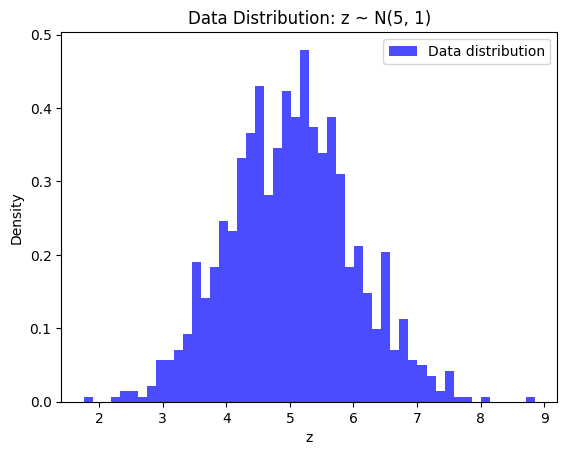

In [2]:
n_samples = 1000
z_data = np.random.normal(loc = 5.0, scale = 1.0, size = n_samples)

# Convert to PyTorch tensor 
z_data = torch.tensor(z_data, dtype = torch.float32).to(device)

# Visualize the data distribution 
plt.hist(z_data.cpu().numpy(), bins=50, density=True, alpha=0.7, color='blue', label='Data distribution')
plt.title("Data Distribution: z ~ N(5, 1)")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()

### **2. Define the Neural Network**

We need a neural network $s_\theta(x, t)$ to approximate the score function.  Since $x$ and $t$ are inputs, and we’re in 1D, the network takes a 2D input ($x$ and $t$) and outputs a 1D vector (the velocity). We’ll use a simple feedforward network with a few layers.

In [3]:
class ScoreNet(nn.Module): 
    def __init__(self, hidden_dim = 64): 
        super(ScoreNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, t): 
        if x.dim() == 1: 
            x = x.unsqueeze(-1)
        
        if t.dim() == 1: 
            t = t.unsqueeze(-1)

        inputs = torch.cat([x, t], dim = -1) # Shape: (batch_size, 2)
        return self.net(inputs)
    
model = ScoreNet().to(device)

### **Step 3: Derive the target score function**

We want to train a model to approximate the score function of a conditional Gaussian:

$$
p_t(x \mid z) = \mathcal{N}(x; \alpha_t z, \beta_t^2 I)
$$

From standard Gaussian identities, the **score function** is:

$$
\nabla_x \log p_t(x \mid z) = -\frac{x - \alpha_t z}{\beta_t^2}
$$


So, first we define a neural network $s_\theta^t(x)$ to approximate the score. The **score matching loss** is:

$$
\mathcal{L}_{\text{CSM}}(\theta) = \mathbb{E}_{t, z, x \sim p_t(\cdot \mid z)} \left[ \left\| s_\theta^t(x) - \nabla_x \log p_t(x \mid z) \right\|^2 \right]
$$

Substituting the analytic score expression:

$$
\mathcal{L}_{\text{CSM}}(\theta) = \mathbb{E}_{t, z, x \sim p_t(\cdot \mid z)} \left[ \left\| s_\theta^t(x) + \frac{x - \alpha_t z}{\beta_t^2} \right\|^2 \right]
$$


From the Gaussian reparameterization trick:

$$
x = \alpha_t z + \beta_t \epsilon, \quad \text{where } \epsilon \sim \mathcal{N}(0, I)
$$

Substitute into the loss:

$$
\mathcal{L}_{\text{CSM}}(\theta) = \mathbb{E}_{t, z, \epsilon \sim \mathcal{N}(0, I)} \left[
\left\| s_\theta^t(\alpha_t z + \beta_t \epsilon) + \frac{\alpha_t z + \beta_t \epsilon - \alpha_t z}{\beta_t^2} \right\|^2
\right]
$$

Simplify:

$$
= \mathbb{E}_{t, z, \epsilon} \left[
\left\| s_\theta^t(\alpha_t z + \beta_t \epsilon) + \frac{\epsilon}{\beta_t} \right\|^2
\right]
$$


Multiplying inside the norm by $\beta_t$, we get:

$$
\mathcal{L}_{\text{rescaled}}(\theta) = \mathbb{E}_{t, z, \epsilon} \left[
\left\| \beta_t s_\theta^t(\alpha_t z + \beta_t \epsilon) + \epsilon \right\|^2
\right]
$$


Let the model predict noise directly by defining:

$$
\epsilon_\theta^t(x) := -\beta_t s_\theta^t(x)
$$

Then the loss becomes:

$$
\mathcal{L}_{\text{DDPM}}(\theta) = \mathbb{E}_{t, z, \epsilon} \left[
\left\| \epsilon_\theta^t(\alpha_t z + \beta_t \epsilon) - \epsilon \right\|^2
\right]
$$

### **4.Train the score network**

Epoch [500/5000], Loss: 0.5542
Epoch [1000/5000], Loss: 0.6221
Epoch [1500/5000], Loss: 0.4707
Epoch [2000/5000], Loss: 0.4901
Epoch [2500/5000], Loss: 0.6367
Epoch [3000/5000], Loss: 0.4588
Epoch [3500/5000], Loss: 0.5484
Epoch [4000/5000], Loss: 0.5718
Epoch [4500/5000], Loss: 0.5330
Epoch [5000/5000], Loss: 0.4701


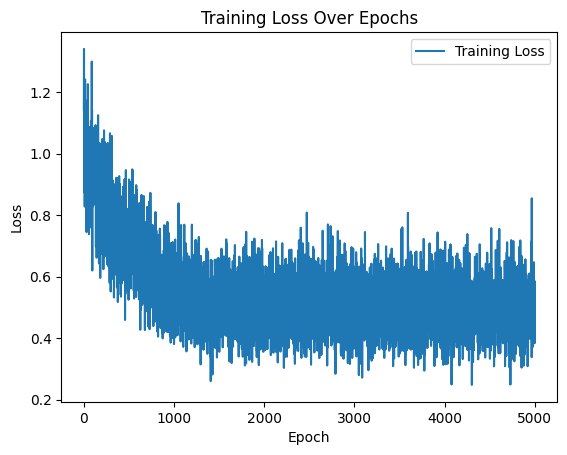

In [4]:
batch_size = 128
n_epochs = 5000
learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

losses = [] 

for epoch in range(n_epochs): 
    # Step 1: Sample a mini-batch of z 
    indices = np.random.choice(n_samples, batch_size)
    z = z_data[indices].unsqueeze(-1) # Shape: (batch_size, 1)

    # Step 2: Sample t ~ Unif[0, 1]
    t = torch.rand(batch_size, device = device) # Shape: (batch_size, )

    # Step 3: Sample noise epsilon ~ N(0, 1)
    epsilon = torch.randn(batch_size, 1, device=device) # Shape: (batch_size, 1)

    # Step 4: Compute x_t = t*z + (1-t)*epsilon
    x_t = t.unsqueeze(-1)*z + (1 - t.unsqueeze(-1))*epsilon # Shape: (batch_size, 1)

    # Step 5: Compute the model prediction s_theta(x_t, t)
    s_theta = model(x_t, t) # Shape: (batch_size, 1)

    # Step 6: Compute epsilon theta = -s_theta*(1-t)
    epsilon_theta = -s_theta * (1-t).unsqueeze(-1)

    # Step 7: Compute the loss
    loss = torch.mean((epsilon_theta - epsilon)**2)

    # Step 8: Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store the loss
    losses.append(loss.item())
    
    # Print progress every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

# Plot the training loss
plt.plot(losses, label='Training Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### **5. Visualize the results**

In [5]:
#Visualization: Sample a few data points
z_samples = torch.tensor([4.0, 5.0, 6.0], device=device).unsqueeze(-1)  # Shape: (3, 1)

# Time steps for visualization
t_values = torch.linspace(0, 0.9, 100, device=device)  # Shape: (100,)

# Store paths and scores for plotting
paths = {z.item(): [] for z in z_samples}
s_predictions = {z.item(): [] for z in z_samples}
s_targets = {z.item(): [] for z in z_samples}

# Compute paths and scores
model.eval()
with torch.no_grad():
    for t in t_values:
        t_batch = t.repeat(z_samples.shape[0]).unsqueeze(-1)  # Shape: (3, 1)
        epsilon = torch.randn(z_samples.shape, device=device)  # Shape: (3, 1)
        
        # Compute x_t = t*z + (1-t)*epsilon
        x_t = t * z_samples + (1 - t) * epsilon
        
        # Compute the true score: -(x_t - t*z) / (1-t)^2
        # Avoid division by zero at t=1 by using a small epsilon
        t_safe = torch.clamp(t, max=0.999)  # Prevent t=1
        true_score = -(x_t - t_safe * z_samples) / ((1 - t_safe) ** 2)  # Shape: (3, 1)
        
        # Compute the model's predicted score s_theta(x_t, t)
        s_theta = model(x_t, t_batch.squeeze())  # Shape: (3, 1)
        
        # Store for plotting
        for i, z_val in enumerate(z_samples):
            paths[z_val.item()].append(x_t[i].item())
            s_predictions[z_val.item()].append(s_theta[i].item())
            s_targets[z_val.item()].append(true_score[i].item())

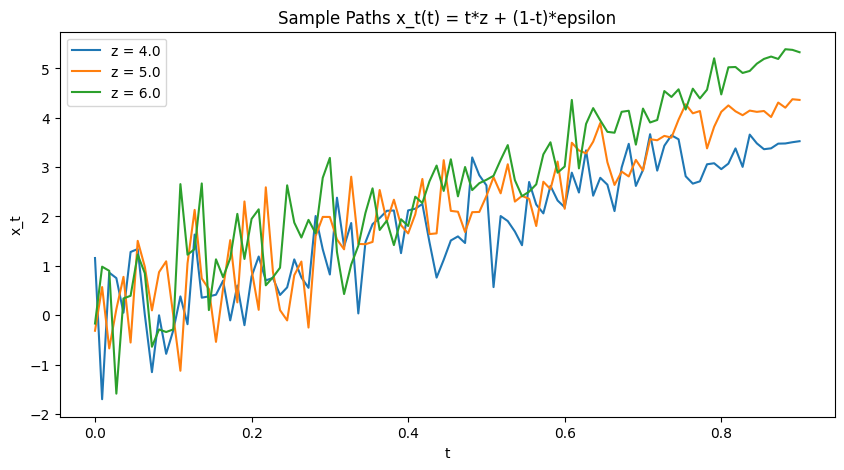

In [6]:
# Plot the paths x_t(t)
plt.figure(figsize=(10, 5))
for z_val, path in paths.items():
    plt.plot(t_values.cpu().numpy(), path, label=f'z = {z_val:.1f}')
plt.title("Sample Paths x_t(t) = t*z + (1-t)*epsilon")
plt.xlabel("t")
plt.ylabel("x_t")
plt.legend()
plt.show()

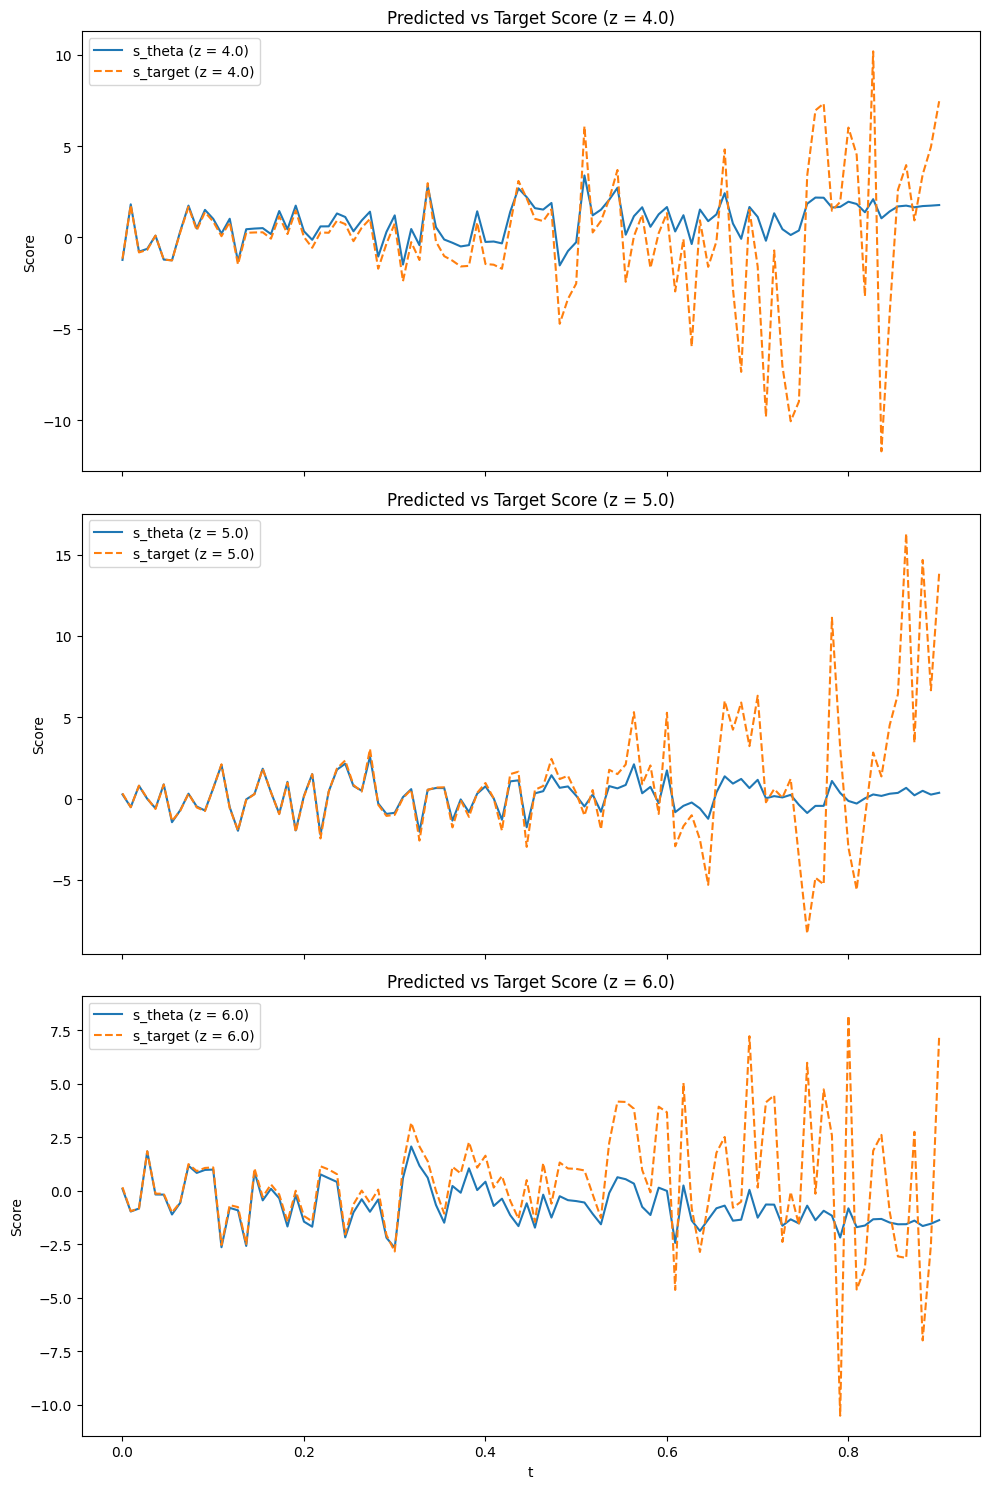

In [7]:
# Plot the predicted vs target scores in three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

z_vals = list(paths.keys())
assert len(z_vals) == 3, "Expected exactly 3 z values for plotting"

for i, (z_val, ax) in enumerate(zip(z_vals, axes)):
    ax.plot(t_values.cpu().numpy(), s_predictions[z_val], label=f's_theta (z = {z_val:.1f})', linestyle='-')
    ax.plot(t_values.cpu().numpy(), s_targets[z_val], label=f's_target (z = {z_val:.1f})', linestyle='--')
    ax.set_title(f'Predicted vs Target Score (z = {z_val:.1f})')
    ax.set_ylabel('Score')
    ax.legend()

axes[-1].set_xlabel('t')
plt.tight_layout()
plt.show()